In [123]:
import openmeteo_requests
import pandas as pd
import requests_cache
from datetime import timedelta, date, datetime

from retry_requests import retry
import plotly.express as px
import plotly.graph_objects as go
from scipy.fft import dct, idct
import numpy as np


In [2]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [3]:
cities = {
    'Oslo':
        {"price_area_code": "NO1",
         "longitude": 10.7461,
         "latitude": 59.9127
        },
    'Kristiansand':
        {"price_area_code": "NO2",
         "longitude": 7.9956,
         "latitude": 58.1467
        },
    'Trondheim':
        {"price_area_code": "NO3",
         "longitude": 10.3951,
         "latitude": 63.4305        
        },
    'Tromsø':
        {"price_area_code": "NO4",
         "longitude": 18.9551,
         "latitude": 69.6489        
        },
    'Bergen':
        {"price_area_code": "NO5",
         "longitude": 5.3242,
         "latitude": 60.393        
        }
    }

In [4]:
df_hourly = pd.DataFrame(cities)

In [5]:
df_hourly

,Oslo,Kristiansand,Trondheim,Tromsø,Bergen
price_area_code,NO1,NO2,NO3,NO4,NO5
longitude,10.7461,7.9956,10.3951,18.9551,5.3242
latitude,59.9127,58.1467,63.4305,69.6489,60.393


In [61]:
def create_dates(year):
    start = f'{year}-01-01'
    end = f'{year}-12-31'
    return start, end

In [73]:
def fetch_data(longitude, latitude, year):
    start, end = create_dates(year)
    params = {
	"latitude": latitude,
	"longitude": longitude,
    "start_date": start,
    "end_date": end,
	"hourly": ["temperature_2m_2m", "precipitation", "wind_speed_10m", "wind_gusts_10m", "wind_direction_10m"],
    }
    url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    responses = openmeteo.weather_api(url, params=params)
    return responses

In [74]:
year = 2019
responses = fetch_data(df_hourly.Bergen.longitude, df_hourly.Bergen.latitude, year)

In [116]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m_2m"] = hourly_temperature_2m_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

df_hourly_hourly = pd.DataFrame(data = hourly_data)

Coordinates: 60.390037536621094°N 5.3183135986328125°E
Elevation: 17.0 m asl
Timezone difference to GMT+0: 0s


In [117]:
df_hourly_hourly.head()

,date,temperature_2m,precipitation,wind_speed_10m,wind_gusts_10m,wind_direction_10m
0,2019-01-01 00:00:00+00:00,5.772,0.2,41.036842,107.279991,277.561340
1,2019-01-01 01:00:00+00:00,6.072,0.7,42.033756,111.959999,286.417297
2,2019-01-01 02:00:00+00:00,6.322,0.5,40.913490,105.839996,298.368958
3,2019-01-01 03:00:00+00:00,5.822,1.1,41.238468,110.159996,315.000092
4,2019-01-01 04:00:00+00:00,5.722,0.7,44.140755,107.279991,322.288879


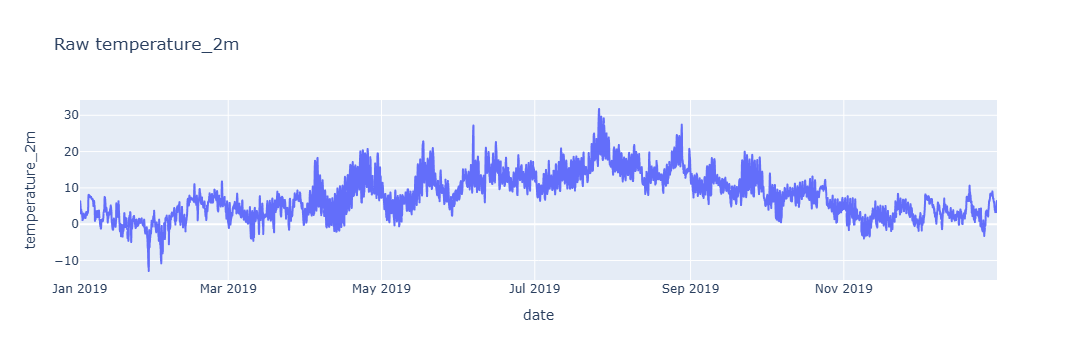

In [134]:
fig = px.line(df_hourly, x="date", y="temperature_2m", title='Raw temperature_2m')
fig.show()

In [154]:
def plot_summary_temperature(df, cutoff=100, k=3.0):
    """
    Input:
    df : pd.DataFrame
    cutoff : int
    k : float

    Returns
    -------
    fig : plotly.graph_objects.Figure
    summary : pd.DataFrame
    """

    df = df_hourly.copy()
    
    # High pass filtering
    temp_dct_ortho = dct(df.temperature_2m, norm='ortho')

    temp_dct_ortho[:cutoff] = 0
    df['temp_highpass'] = idct(temp_dct_ortho, norm='ortho')

    # Seasonally adjusted temperature variations
    median_satv = np.median(temp_highpass)
    mad_satv = np.median(np.abs(temp_highpass - median_satv))
    
    k = 3.0  # typical SPC multiplier
    ucl = median_satv + k * mad_satv
    lcl = median_satv - k * mad_satv
    
    df['is_outlier'] = (df['temp_highpass'] > ucl) | (df['temp_highpass'] < lcl)

    # Plotting
    fig = go.Figure()
    
    # Original temperature_2m trace
    fig.add_trace(go.Scatter(
        x=df_hourly['date'],
        y=df_hourly['temperature_2m'],
        mode='lines',
        name='Original temperature'
    ))

# Seasonally adjusted (high-pass) temperature_2m (non-outliers)
#fig.add_trace(go.Scatter(
 #   x=df_hourly.loc[~df_hourly['is_outlier'], 'date'],
  #  y=df_hourly.loc[~df_hourly['is_outlier'], 'temperature_2m'],
   # mode='markers',
    #name='Inliers',
    #marker=dict(color='blue', size=4),
#))

    # Outliers
    fig.add_trace(go.Scatter(
        x=df.loc[df['is_outlier'], 'date'],
        y=df.loc[df['is_outlier'], 'temperature_2m'],
        mode='markers',
        name='Outliers',
        marker=dict(color='red', size=4, symbol='circle'),
    ))

    # SPC boundaries (horizontal lines)
    fig.add_trace(go.Scatter(
        x=[df['date'].min(), df['date'].max()],
        y=[ucl, ucl],
        mode='lines',
        name='UCL (Upper Control Limit)',
        line=dict(color='green', dash='dash')
    ))
    
    fig.add_trace(go.Scatter(
        x=[df['date'].min(), df['date'].max()],
        y=[lcl, lcl],
        mode='lines',
        name='LCL (Lower Control Limit)',
        line=dict(color='green', dash='dash')
    ))
    
    # Layout
    fig.update_layout(
        title='Temperature with SPC Outlier Detection (Seasonally Adjusted via DCT)',
        xaxis_title='Date',
        yaxis_title='Temperature (°C)',
        template='plotly_white',
        legend=dict(yanchor='top', y=0.98, xanchor='left', x=0.01),
        height=600
    )
    
    
    summary = df.loc[df['is_outlier'], ['date', 'temperature_2m', 'temp_highpass']].copy()
    summary['deviation'] = df.loc[df['is_outlier'], 'temp_highpass'] - median_satv
    summary['limit'] = np.where(summary['temp_highpass'] > ucl, 'above UCL', 'below LCL')

    return fig, summary

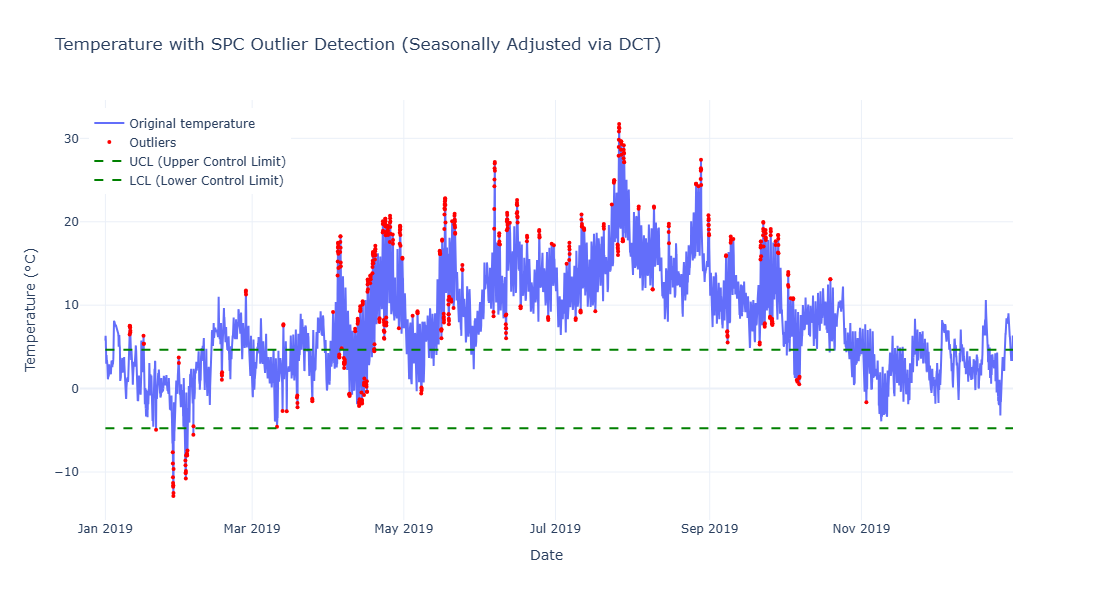

Outlier Summary:
                         date  temperature_2m  temp_highpass  deviation  \
234 2019-01-10 18:00:00+00:00           6.472       4.724131   4.764295   
235 2019-01-10 19:00:00+00:00           7.522       5.764941   5.805105   
236 2019-01-10 20:00:00+00:00           7.472       5.704797   5.744960   
237 2019-01-10 21:00:00+00:00           7.472       5.693722   5.733885   
238 2019-01-10 22:00:00+00:00           7.372       5.581739   5.621903   

         limit  
234  above UCL  
235  above UCL  
236  above UCL  
237  above UCL  
238  above UCL  

Total outliers detected: 491


In [155]:
fig, summary = plot_summary_temperature(df = df_hourly)

# Show results
fig.show()
print("Outlier Summary:")
print(summary.head())
print(f"\nTotal outliers detected: {len(summary)}")

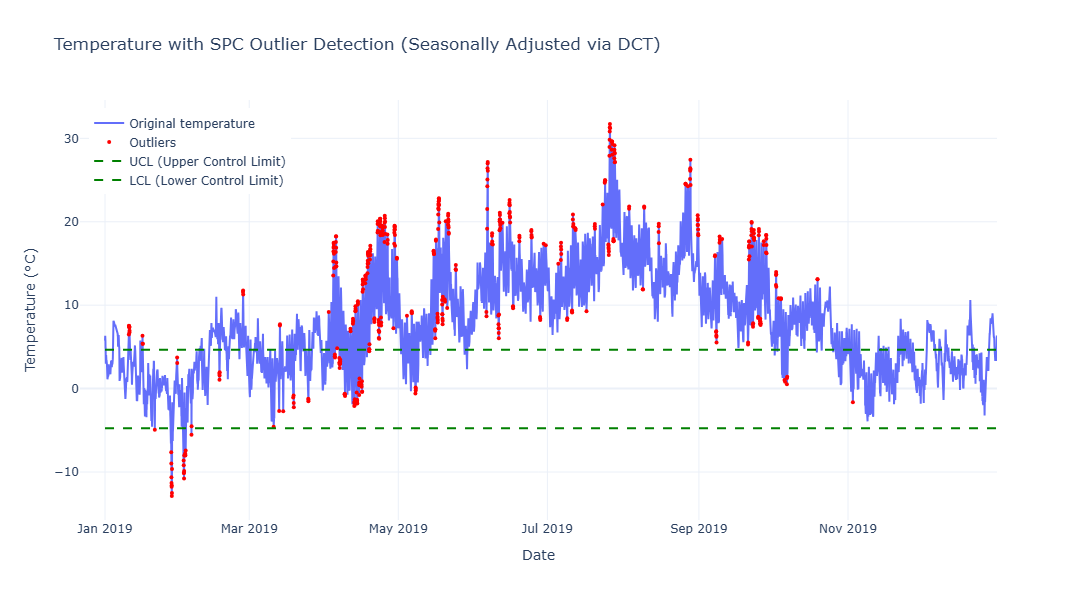